In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import linear_model
from datasetStuff import expandDataset, assessFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier

In [48]:
data=np.load("first_batch_with_labels_likes.npz")
data2=np.load("second_batch_with_labels_likes.npz")
df = expandDataset(data, more_features=False).getDataset()
df2 = expandDataset(data2, more_features=False).getDataset()

In [49]:
# df = pd.concat([df,df2]).reset_index(drop=True)

In [113]:
fakeDF = df2.loc[df2['label']==1]

df_c = pd.concat([df,df2]).reset_index(drop=True)
labels = df_c['label']

In [53]:
df_c.columns

Index(['average_rating', 'likes', 'dislikes', 'meh', 'interaction_balance',
       'balance_ratio', 'followed majority', 'followed majority %',
       'rating_val', 'no_rating', 'num_pop_liked', 'num_unpop_liked',
       'num_pop_disliked', 'num_unpop_disliked'],
      dtype='object')

In [116]:
df_c = df_c.drop(['user','label','mean','std','cv','total_interactions','likes_ratio','dislikes_ratio','neutral_ratio','neutral_ratings','likes','dislikes','meh'],axis=1)

In [28]:
sparse_feat = pd.read_csv("./csv_files/sparse_features.csv")

In [16]:
sparse_feat = sparse_feat.drop(['Unnamed: 0'],axis=1)
# sparse_feat = sparse_feat.drop(list(set(df.columns)&set(sparse_feat.columns)),axis=1)

In [17]:
labels = sparse_feat['label']
test_PCA = sparse_feat.drop(['label'],axis=1)

In [119]:
# test = sparse_feat.merge(df_c, left_index=True, right_index=True)
# test = test.drop([f"{i}" for i in range(0,1000)],axis=1)

In [7]:
# assessor = assessFeatures(test_PCA, list(labels))
# selected = assessor.select_by_boruta()

In [24]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=500)
transformed_test = pca_test.fit_transform(test_PCA)

In [25]:
transformed_test

array([[-1.29936889e+03, -5.64029193e+01,  3.69852347e+00, ...,
         4.46897378e-01, -2.82023849e-01, -2.29863508e-01],
       [-1.29804116e+03, -1.91992290e+02,  6.05399161e-01, ...,
         2.07941229e-01,  1.18534416e-01,  2.72894558e-02],
       [-1.29748094e+03,  3.31613489e+00,  4.22967133e+01, ...,
        -5.66399747e-01,  2.78585865e-01,  5.14767006e-01],
       ...,
       [ 1.29731199e+03,  6.38501046e+01, -3.98836046e+01, ...,
         1.01951464e+00,  3.51288658e-01,  1.19994618e+00],
       [ 1.29776065e+03,  3.53250797e+02,  8.84088692e+01, ...,
        -7.06859453e-02,  3.56333530e-01,  3.73060047e-01],
       [ 1.29975880e+03, -9.28919344e+01,  3.03170296e+01, ...,
        -1.10332565e+00,  3.45774041e-01,  2.36741972e-01]])

In [22]:
principal_test_Df = pd.DataFrame(data = transformed_test
             , columns = ['principal component 1', 'principal component 2'])
principal_test_Df

ValueError: Shape of passed values is (2600, 5), indices imply (2600, 2)

<Figure size 640x480 with 0 Axes>

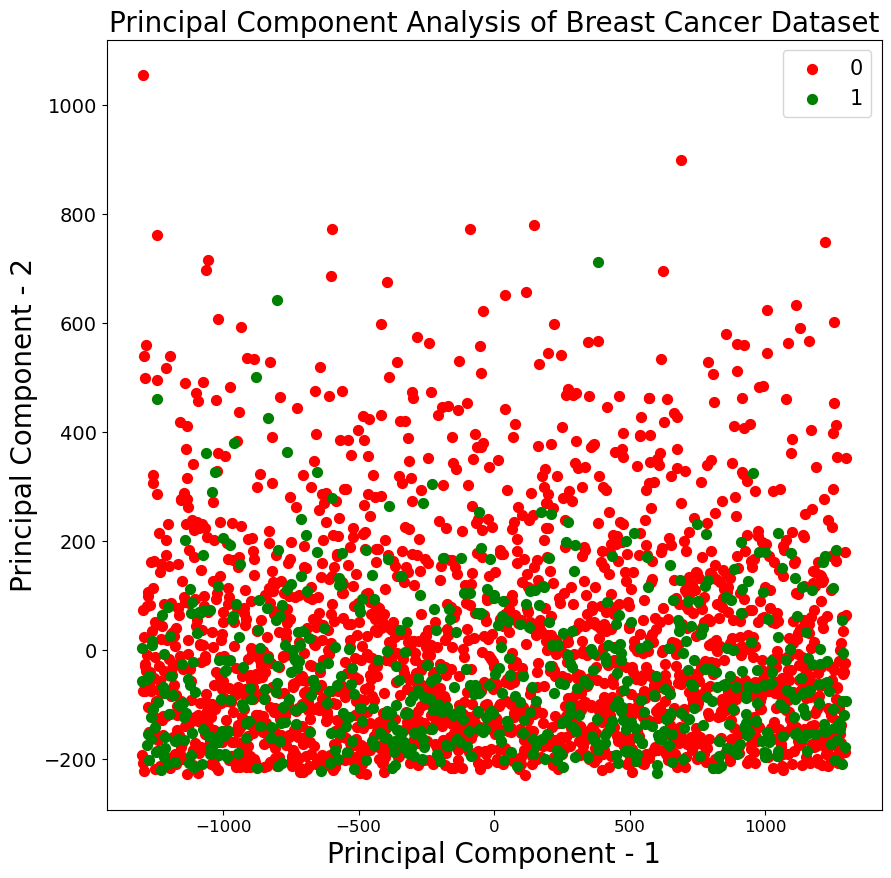

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = labels == target
    plt.scatter(principal_test_Df.loc[indicesToKeep, 'principal component 1']
               , principal_test_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})


In [11]:
# indicesToKeep = df_c['label'] == target

In [12]:
# principal_test_Df.loc[list(indicesToKeep)]

In [48]:
assessor = assessFeatures(df)

In [ ]:
classifier = linear_model.LogisticRegression(solver='liblinear')
best_features = assessor.select_by_ANOVA(2)

In [2]:
def getScores(true, pred):
    fpr, tpr, thresholds = roc_curve(true,pred)
    auc_score = roc_auc_score(true,pred)

    best_threshold = (tpr+(1-fpr)/2)
    best_threshold = thresholds[np.argmax(best_threshold)]

    pred_threshold = (pred >= best_threshold).astype(int)
    precision = precision_score(true, pred_threshold)
    recall = recall_score(true, pred_threshold)
    f1 = f1_score(true, pred_threshold)

    return {"AUC": auc_score, "f1":f1, "recall":recall, "precision":precision}

In [3]:
def test_on_model(model, df, labels):
    X_train, X_val, y_train, y_val = train_test_split(df, labels, test_size=0.2, random_state=42, stratify=labels)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model.fit(X_train_scaled,y_train)
    prediction = model.predict_proba(X_val_scaled)[:,1]

    prediction = (prediction >= 0.5).astype(int)

    return roc_auc_score(y_val, prediction)


In [ ]:
# model = linear_model.LogisticRegression(solver='saga', max_iter=1000)
# best_df = df[best_features]
# labels = df['label']

# test_on_model(model, best_df, labels)

In [4]:
# Training a 2-layer neural network
# Define the hyperparameters
hidden_layer_sizes = (50, 10)  # The number of neurons in each hidden layer
activation = 'relu'  # Activation function for the hidden layers ('logistic', 'tanh', 'relu', etc.)
solver = 'adam'  # The optimization algorithm ('adam', 'sgd', 'lbfgs', etc.)
alpha = 0.0001  # L2 regularization parameter
learning_rate = 'adaptive'  # The learning rate schedule for weight updates ('constant', 'invscaling', 'adaptive')
max_iter = 2000  # Maximum number of iterations
random_state = 42  # Seed for random initialization

mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    solver=solver,
    alpha=alpha,
    learning_rate=learning_rate,
    max_iter=max_iter,
    random_state=random_state,
    batch_size=410,
    beta_1=0.7,
    beta_2=0.994
)

In [20]:
perf = []

# model = linear_model.LogisticRegression(solver='sag', max_iter=1000, class_weight={0:0.4, 1:1})
model = mlp
labels = df['label']

for i in range(1, 7):
    best_features = assessor.select_by_RFE(mlp, i)
    best_df = df[best_features]
    score = test_on_model(model, best_df, labels)
    perf.append({'num_feat':i,'score':score})

pd.DataFrame(perf).sort_values(by='score', ascending=False)

NameError: name 'mlp' is not defined

In [5]:
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Lars
from sklearn.linear_model import LinearRegression, Ridge, OrthogonalMatchingPursuit, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import ARDRegression, BayesianRidge, PoissonRegressor, TweedieRegressor, GammaRegressor
from sklearn.linear_model import HuberRegressor, TheilSenRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

names = [
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "Logistic Regression",
    "Ridge Classifier",
    "SGD Classifier",
    "Lars",
    "Linear Regression",
    "Ridge",
    "Orthogonal Matching Pursuit",
    "LassoLars CV",
    "LassoLars IC",
    "ARD Regression",
    "Bayesian Ridge",
    "Huber Regressor",
    "Theil Sen Regressor",
    "Poisson Regressor",
    "Tweedie Regressor",
    # "Gamma Regressor"
]

classifiers = [
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    LogisticRegression(max_iter=10000, random_state=42),
    RidgeClassifier(max_iter=10000, random_state=42),
    SGDClassifier(max_iter=10000, random_state=42),
    Lars(random_state=42),
    LinearRegression(),
    Ridge(random_state=42),
    OrthogonalMatchingPursuit(),
    LassoLarsCV(),
    LassoLarsIC(),
    ARDRegression(),
    BayesianRidge(),
    HuberRegressor(),
    TheilSenRegressor(),
    PoissonRegressor(),
    TweedieRegressor(),
    # GammaRegressor()
]

In [6]:
import tensorflow as tf

In [49]:
hist = []

# df_fake = df.loc[df['label']==1]
# df_nonfake = df.loc[df['label']==0].sample(600)
# df_balanced = pd.concat([df_fake,df_nonfake])
# labels = df_balanced['label']

classifier = LogisticRegression()

for i in range(1,len(df.columns)-2):
    hist_inner = {f"{i}":[], "best_score":0}
    best_features = assessor.select_by_RFE(classifier, i)

    labels = df['label']
    df_final = df.drop(['user','label'],axis=1)
    # df_final = df_final[best_features]
    df_final = best_features

    X, y = df_final, labels
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        # clf.class_weight = {0:0.3, 1:1}
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = roc_auc_score(y_test, y_pred)
        hist_inner[str(i)].append({'clf':name, 'auc':score})

        if score > hist_inner['best_score']:
            hist_inner['best_score'] = score

    hist.append(hist_inner)


c:\Users\zorko\anaconda3\envs\cs421\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zorko\anaconda3\envs\cs421\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [50]:
results_table = pd.DataFrame(hist).sort_values(by='best_score', ascending=False)

In [54]:
pd.DataFrame(results_table.iloc[0][17]).sort_values(by='auc')

,clf,auc
9,Lars,0.614000
8,SGD Classifier,0.651667
1,RBF SVM,0.674167
5,Naive Bayes,0.685833
4,AdaBoost,0.690000
2,Gaussian Process,0.728333
3,Neural Net,0.730833
0,Linear SVM,0.732500
7,Ridge Classifier,0.750833
12,Orthogonal Matching Pursuit,0.750854


In [43]:
pd.DataFrame(results_table.iloc[0][28]).sort_values(by='auc')

ValueError: DataFrame constructor not properly called!

##### With added fakes: ARDRegression - 0.909458 AUC

In [33]:
clf = LassoLarsIC()

best_features = assessor.select_by_ANOVA(28)

labels = df['label']
df_final = df.drop(['user','label'],axis=1)
df_final = best_features
X, y = df_final, labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf.class_weight = {0:0.3, 1:1}
clf = make_pipeline(StandardScaler(), clf)

# Scaling the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X)
# X_val_scaled = scaler.transform(X_val)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
balanced_accuracy = (tpr + (1 - fpr)) / 2
best_threshold = thresholds[np.argmax(balanced_accuracy)]

In [ ]:
y_pred_best = (y_pred >= best_threshold).astype(int)
roc_auc_score(y_test, y_pred_best)

In [ ]:
results_table.to_csv("performance_with_alot.csv")

In [ ]:
classifier = SVC(kernel="linear", C=0.025, random_state=42)
classifier.fit()

In [21]:
df = pd.read_csv("./csv_files/f_s_t_f_expanded_sparse.csv")

In [22]:
labels = df['label']
df = df.drop(['Unnamed: 0','user','label'],axis=1)

In [12]:
assessor = assessFeatures(df,labels)

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import joblib

classifier = LogisticRegression()
# best_features = assessor.select_by_RFE(classifier, 17)

# labels = df['label']
y = labels
X = df

# Use StratifiedKFold for k-fold cross-validation (assuming binary classification)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores
classifier_scores = []

for name, clf in zip(names, classifiers):

    clf = make_pipeline(StandardScaler(), clf)

    roc_auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Perform k-fold cross-validation
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit the model
        clf.fit(X_train, y_train)

        # Predict probabilities for the validation set
        mlp_probs = clf.predict(X_val)
        fpr, tpr, thresholds = roc_curve(y_val, mlp_probs)
        balanced_accuracy = (tpr + (1 - fpr)) / 2
        threshold = thresholds[np.argmax(balanced_accuracy)]   

        # Convert probabilities to binary predictions using a threshold (e.g., 0.5)
        mlp_preds = (mlp_probs >= threshold).astype(int)

        # Calculate and store scores
        roc_auc_scores.append(roc_auc_score(y_val, mlp_probs))
        precision_scores.append(precision_score(y_val, mlp_preds))
        recall_scores.append(recall_score(y_val, mlp_preds))
        f1_scores.append(f1_score(y_val, mlp_preds))

    # model_filename = 'mlp_model.pkl'
    # joblib.dump(mlp, model_filename)

    # Print the mean scores
    classifier_scores.append({'clf':name,'auc':np.mean(roc_auc_scores),'precision':np.mean(precision_scores), 'recall':np.mean(recall_scores), 'f1':np.mean(f1_scores)}) 

scores = pd.DataFrame(classifier_scores).sort_values(by='auc', ascending=False)

c:\Users\zorko\anaconda3\envs\cs421\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zorko\anaconda3\envs\cs421\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zorko\anaconda3\envs\cs421\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zorko\anaconda3\envs\cs421\lib\site-packages\sklearn\metrics\_classification

KeyboardInterrupt: 

In [24]:
scores = pd.DataFrame(classifier_scores).sort_values(by='auc', ascending=False)
scores

,clf,auc,precision,recall,f1
15,ARD Regression,0.883998,0.537154,0.804545,0.641758
14,LassoLars IC,0.880503,0.528557,0.800000,0.634372
13,LassoLars CV,0.877935,0.567100,0.763636,0.646961
16,Bayesian Ridge,0.860867,0.524168,0.776364,0.620362
12,Orthogonal Matching Pursuit,0.859340,0.517269,0.772727,0.617487
10,Linear Regression,0.852797,0.532055,0.762727,0.626309
11,Ridge,0.849443,0.533007,0.767273,0.626888
17,Huber Regressor,0.838539,0.535058,0.720909,0.610726
3,Neural Net,0.784477,0.754791,0.625455,0.683402
4,AdaBoost,0.767330,0.776414,0.580909,0.664280


##### With added fakes: ARDRegression - 0.905475 AUC - 0.917399 Precision - 0.761667 Recall - 0.831730 F1
##### With whole dataset added: ARDRegression is best, however in previous run it scored ~0.88
##### With added fakes + less features: LinearRegression - 0.902483 AUC - 0.913084 Precision - 0.768333 Recall - 0.833604 F1

In [2]:
data=np.load("first_batch_with_labels_likes.npz")
df = expandDataset(data, more_features=True).getDataset()
assessor = assessFeatures(df)

In [3]:
df_final = assessor.select_by_boruta()
labels = assessor.labels

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	18
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	18
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	18
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	18
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	14
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	14
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	14
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	14
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	14
Rejec

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tf.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

X = df_final
y = labels
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

zero_weight = np.sum(y_train==1)/np.sum(y_train==0)

# Check if GPU is available and set the appropriate device
if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    print(f'GPU found: {device_name}')
else:
    print('No GPU found. Using CPU.')

input_shape = len(X.columns)

# Create a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid'),
])

# Convert target labels to one-hot encoding
y_train_categorized, y_val_categorized = to_categorical(y_train, num_classes=2), to_categorical(y_val, num_classes=2)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

# Train the model
history = model.fit(X_train_scaled, y_train_categorized, epochs=20, batch_size=int(len(X)/1), class_weight={0:zero_weight, 1:1}, validation_data=(X_val_scaled, y_val_categorized))

In [ ]:
# history = model.fit(X_train_scaled, y_train_categorized, epochs=200, batch_size=int(len(X)/1), class_weight={0:zero_weight, 1:1}, validation_data=(X_val_scaled, y_val_categorized))

In [ ]:
y_pred = model.predict(X_val_scaled)[:,1]
getScores(y_val, y_pred)